# 量化策略回测框架 - ConvLSTM模型集成

In [1]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style, Back
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path
import warnings
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
import gc  # 用于内存管理

# 忽略Pandas在特定操作中可能产生的无害警告
warnings.filterwarnings('ignore', category=UserWarning)

# 配置日志输出格式
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')

# 启用GPU加速（如果可用）
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 限制GPU内存增长
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        logging.info(f"{len(gpus)} 个物理GPU, {len(logical_gpus)} 个逻辑GPU")
    except RuntimeError as e:
        logging.error(f"GPU配置错误: {e}")

2025-07-30 15:56:55.731661: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 15:56:55.733127: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 15:56:55.737474: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 15:56:55.747130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753862215.762258  206935 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753862215.76

---
## ConvLSTM模型构建与训练

In [2]:
def build_conv_lstm_model(input_shape, num_features):
    """
    构建改进版ConvLSTM混合模型架构
    
    改进点:
    1. 增加卷积层深度
    2. 添加残差连接
    3. 调整Dropout比例
    4. 优化全连接层结构
    """
    # 输入层
    inputs = Input(shape=input_shape)
    
    # 1D卷积分支 - 提取局部特征
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.3)(conv1)
    
    conv2 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.3)(conv2)
    
    # 添加第三个卷积层
    conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.3)(conv3)
    
    # 残差连接
    conv_res = concatenate([conv1, conv3])
    
    # LSTM分支 - 捕捉时序依赖
    lstm1 = LSTM(128, return_sequences=True)(inputs)
    lstm1 = BatchNormalization()(lstm1)
    lstm1 = Dropout(0.3)(lstm1)
    
    lstm2 = LSTM(256, return_sequences=False)(lstm1)
    lstm2 = BatchNormalization()(lstm2)
    lstm2 = Dropout(0.4)(lstm2)
    
    # 合并分支
    merged = concatenate([Flatten()(conv_res), lstm2])
    
    # 全连接层
    dense1 = Dense(512, activation='relu')(merged)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.5)(dense1)
    
    dense2 = Dense(256, activation='relu')(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.4)(dense2)
    
    # 输出层 - 三分类(做多/做空/中性)
    outputs = Dense(3, activation='softmax')(dense2)
    
    # 创建模型
    model = Model(inputs=inputs, outputs=outputs)
    
    # 编译模型
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [3]:
def prepare_rolling_data(factor_data, lookback=60, test_size=0.2):
    """
    准备滚动训练数据（改进版）
    
    改进点:
    1. 包含所有特征列（除了明确排除的）
    2. 添加特征筛选
    """
    logging.info("📊 准备滚动训练数据...")
    
    # 定义不应作为模型输入特征的列
    EXCLUDED_FEATURES = ['open_time', 'open', 'high', 'low', 'close', 'volume', 
                         'close_time', 'turnover', 'trade_count', 
                         'taker_buy_volume', 'taker_buy_turnover']
    
    # 筛选出所有不在排除列表中的列作为模型的输入特征
    feature_columns = [col for col in factor_data.columns if col not in EXCLUDED_FEATURES]
    
    # 过滤掉方差过低的特征
    feature_variance = factor_data[feature_columns].var()
    valid_features = feature_variance[feature_variance > 1e-5].index.tolist()
    
    logging.info(f"原始特征数: {len(feature_columns)}, 有效特征数: {len(valid_features)}")
    
    features = factor_data[valid_features].values
    
    # 创建目标变量 - 未来10期收益率方向 
    future_returns = factor_data['close'].pct_change(10).shift(-10)
    y = np.zeros(len(future_returns))
    
    # 调整分类阈值
    # 分类标签: 1(做多), -1(做空), 0(中性)
    y[future_returns > 0.008] = 1    # 显著上涨
    y[future_returns < -0.008] = 2   # 显著下跌
    y = tf.keras.utils.to_categorical(y, num_classes=3)
    
    # 创建时间序列样本
    X = []
    valid_indices = []
    
    for i in range(lookback, len(features)):
        X.append(features[i-lookback:i])
        valid_indices.append(i)
    
    X = np.array(X)
    y = y[valid_indices]
    indices = factor_data.index[valid_indices]
    
    logging.info(f"✅ 数据准备完成 - 样本数: {X.shape[0]}, 时间步长: {X.shape[1]}, 特征数: {X.shape[2]}")
    return X, y, indices

In [4]:
def rolling_train_and_predict(X, y, indices, lookback=60, n_splits=5):
    """
    执行滚动训练和预测（改进版）
    
    改进点:
    1. 增加训练轮次
    2. 调整批大小
    3. 优化信号生成逻辑
    """
    logging.info(f"🚀 开始滚动训练 (n_splits={n_splits})...")
    
    # 初始化预测结果数组
    all_predictions = np.zeros((len(y), 3))
    
    # 创建时间序列交叉验证器
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # 用于存储每个折叠的性能
    fold_accuracies = []
    fold_losses = []
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        logging.info(f"\n🔁 处理折叠 {fold+1}/{n_splits}")
        logging.info(f"  训练集: {indices[train_index[0]]} 到 {indices[train_index[-1]]}")
        logging.info(f"  测试集: {indices[test_index[0]]} 到 {indices[test_index[-1]]}")
        
        # 划分训练集和测试集
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # 标准化 - 使用训练集的统计量
        scaler = StandardScaler()
        X_train_2d = X_train.reshape(-1, X_train.shape[-1])
        X_test_2d = X_test.reshape(-1, X_test.shape[-1])
        
        scaler.fit(X_train_2d)
        X_train_scaled = scaler.transform(X_train_2d).reshape(X_train.shape)
        X_test_scaled = scaler.transform(X_test_2d).reshape(X_test.shape)
        
        # 构建模型
        model = build_conv_lstm_model((lookback, X_train.shape[2]), X_train.shape[2])
        
        # 回调函数
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)
        ]
        
        # 训练模型
        history = model.fit(
            X_train_scaled, y_train,
            epochs=50,
            batch_size=256,
            validation_data=(X_test_scaled, y_test),
            callbacks=callbacks,
            verbose=1
        )
        
        # 在测试集上预测
        test_pred = model.predict(X_test_scaled, batch_size=1024, verbose=0)
        all_predictions[test_index] = test_pred
        
        # 评估性能
        test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
        fold_accuracies.append(test_acc)
        fold_losses.append(test_loss)
        logging.info(f"  测试准确率: {test_acc:.4f}, 测试损失: {test_loss:.4f}")
        
        # 清理内存
        del model, X_train, X_test, y_train, y_test
        gc.collect()
        tf.keras.backend.clear_session()
    
    # 打印整体性能
    logging.info(f"\n✅ 滚动训练完成 - 平均准确率: {np.mean(fold_accuracies):.4f}, 平均损失: {np.mean(fold_losses):.4f}")
    
    # 转换预测结果为信号
    signal_labels = np.argmax(all_predictions, axis=1)
    signals = np.zeros(len(indices))
    signals = np.where(signal_labels == 1, 1, np.where(signal_labels == 2, -1, 0))
    
    # 创建信号Series并设置索引
    signal_series = pd.Series(signals, index=indices)
    
    # 改进的信号平滑处理
    # 使用加权移动平均，近期信号权重更高
    weights = np.array([0.1, 0.2, 0.3, 0.4])
    weighted_avg = signal_series.rolling(window=4, min_periods=1).apply(
        lambda x: np.sum(weights[-len(x):] * x) / np.sum(weights[-len(x):]), raw=True
    )
    
    # 动态调整阈值
    signal_strength = weighted_avg.abs().mean()
    long_threshold = max(0.25, 0.25 * signal_strength)
    short_threshold = min(-0.25, -0.25 * signal_strength)
    
    final_signals = pd.Series(
        np.where(weighted_avg > long_threshold, 1, 
                np.where(weighted_avg < short_threshold, -1, 0)),
        index=indices
    )
    
    logging.info(f"📡 信号生成完成 - 做多比例: {(final_signals == 1).mean():.2%}, "
                 f"做空比例: {(final_signals == -1).mean():.2%}")
    
    return final_signals

## 2. 核心回测与评估函数 (保持不变)
(此处保留原有的run_realized_pnl_backtest和evaluate_realized_pnl_performance函数)

In [5]:
def run_realized_pnl_backtest(prices, signals, initial_capital=100000, commission_rate=0.0002, holding_period=10):
    """
    执行基于已实现盈亏的高性能回测。

    本函数为回测框架的核心，其设计严格遵循以下交易逻辑：
    1. **资金管理**: 初始资金被等分为10份，每次开仓使用一份，用于模拟分批建仓。
    2. **单向持仓**: 在任何时间点，所有持仓的方向必须一致（全为多头或全为空头），不允许锁仓或同时持有多空。
    3. **事件驱动**: 交易信号在t-1时刻产生，在t时刻执行。
    4. **固定持有期**: 每份独立的仓位最多持有`holding_period`个周期，到期后自动平仓。
    5. **渐进式调仓**: 当收到与当前持仓方向相反的信号时，仅平掉**最早开立**的一份仓位，而非全部平仓，以实现更平滑的调仓，减少交易冲击。
    6. **已实现盈亏**: 权益曲线的计算完全基于已关闭仓位的真实盈亏，忽略未平仓位的浮动盈亏，使结果更保守稳健。

    性能优化关键点:
    - **预分配数组**: 使用NumPy数组预先分配内存来存储回测结果，避免在循环中动态修改Pandas DataFrame，这是主要的性能提升来源。
    - **高效队列操作**: 利用`collections.deque`的O(1)时间复杂度的`popleft()`和`append()`操作管理活跃仓位。
    - **算法优化**: 检查到期仓位时，仅需检查队列头部的最早仓位，无需遍历整个队列。

    参数:
    - prices (pd.Series): 资产的收盘价序列。
    - signals (pd.Series): 交易信号序列 (1: 做多, -1: 做空, 0: 中性)。
    - initial_capital (float): 初始总资本。
    - commission_rate (float): 单边交易手续费率。
    - holding_period (int): 每份仓位的最大持有周期（单位：K线数量）。

    返回:
    - pd.DataFrame: 包含回测详细过程（如持仓、成本、权益等）的DataFrame。
    - pd.DataFrame: 包含每一笔已完成交易的详细历史记录。
    """
    logging.info("🚀 开始执行优化版回测 (基于已实现盈亏)...")

    n = len(prices)
    # --- 性能优化: 预分配结果存储 ---
    # 将结果存储在字典包裹的NumPy数组中，循环结束后一次性生成DataFrame。
    # 这比在循环中逐行填充DataFrame（如使用.at或.loc）快几个数量级。
    results = {
        'position': np.zeros(n, dtype=np.int8),
        'position_count': np.zeros(n, dtype=np.int8),
        'cost_basis': np.zeros(n),
        'transaction_costs': np.zeros(n),
        'net_returns': np.zeros(n),
        'equity_curve': np.full(n, initial_capital)
    }

    # --- 性能优化: 预提取数据到NumPy数组 ---
    # 在循环开始前将Pandas Series转换为NumPy数组，后续在循环中访问数组元素比访问Series元素更快。
    close_arr = prices.values
    signal_arr = signals.values
    indices = prices.index # 预存索引，用于记录交易历史

    # --- 初始化交易状态变量 ---
    active_positions = deque()  # 使用双端队列(deque)高效管理先进先出的持仓
    realized_pnl = 0.0          # 累计已实现盈亏
    position_direction = 0      # 当前整体持仓方向 (1: 多, -1: 空, 0: 无)
    position_cost = 0.0         # 当前持仓的平均成本价
    trade_history = []          # 记录每一笔完整交易的列表
    capital_per_position = initial_capital / 10 # 每份仓位分配的资金

    # --- 主回测循环 ---
    # 从第二个时间点开始遍历，因为交易决策基于前一天的信号
    for i in range(1, n):
        current_close = close_arr[i]
        prev_signal = signal_arr[i-1]  # 使用t-1的信号决定t时刻的操作
        trades_occurred = False        # 标记当日是否有交易（平仓）发生

        # 1. 处理到期强制平仓
        # --- 性能优化: O(1)复杂度的到期检查 ---
        # 由于active_positions是先进先出队列，我们只需检查队头（最早的仓位）。
        # 如果队头没到期，那么队列中所有其他仓位也一定没到期。
        while active_positions:
            oldest_pos = active_positions[0] # 只看不取
            if i - oldest_pos['entry_index'] >= holding_period:
                # 仓位已到期，执行平仓
                pos_to_close = active_positions.popleft() # 从队列中移除
                exit_price = current_close
                
                # 计算盈亏
                pnl = (exit_price - pos_to_close['entry_price']) * pos_to_close['direction'] * pos_to_close['quantity']
                exit_commission = commission_rate * exit_price * pos_to_close['quantity']
                net_pnl = pnl - exit_commission
                
                # 更新累计已实现盈亏
                realized_pnl += net_pnl
                trades_occurred = True
                
                # 记录交易成本
                results['transaction_costs'][i] += exit_commission
                
                # 记录交易历史
                trade_history.append({
                    'entry_time': indices[pos_to_close['entry_index']], 'exit_time': indices[i],
                    'direction': pos_to_close['direction'], 'entry_price': pos_to_close['entry_price'],
                    'exit_price': exit_price, 'quantity': pos_to_close['quantity'],
                    'pnl': pnl, 'commission': exit_commission, 'net_pnl': net_pnl,
                    'duration': i - pos_to_close['entry_index'], 'type': 'expired'
                })
            else:
                # 最早的仓位都未到期，则无需继续检查
                break

        # 2. 根据新信号处理交易
        if prev_signal != 0:  # 只对非中性信号做出反应
            # 情况A: 当前无任何持仓，且有新信号
            if position_direction == 0:
                # 开立第一份仓位
                quantity = capital_per_position / current_close
                active_positions.append({
                    'direction': prev_signal,
                    'entry_price': current_close,
                    'quantity': quantity,
                    'entry_index': i
                })
                position_direction = prev_signal
                position_cost = current_close
                entry_commission = commission_rate * current_close * quantity
                results['transaction_costs'][i] += entry_commission
                results['position'][i] = prev_signal

            # 情况B: 新信号与当前持仓方向相同 (加仓)
            elif position_direction == prev_signal and len(active_positions) < 10:
                # 如果仓位未满10份，则加开一份新仓
                quantity = capital_per_position / current_close
                active_positions.append({
                    'direction': prev_signal, 'entry_price': current_close,
                    'quantity': quantity, 'entry_index': i
                })
                # 更新平均持仓成本
                total_quantity = sum(p['quantity'] for p in active_positions)
                total_cost = sum(p['entry_price'] * p['quantity'] for p in active_positions)
                position_cost = total_cost / total_quantity
                entry_commission = commission_rate * current_close * quantity
                results['transaction_costs'][i] += entry_commission
                results['position'][i] = prev_signal

            # 情况C: 新信号与当前持仓方向相反 (部分平仓)
            elif position_direction != prev_signal and active_positions:
                # 核心逻辑：只平掉最早的一份仓位，实现渐进式调仓
                pos_to_close = active_positions.popleft()
                exit_price = current_close
                pnl = (exit_price - pos_to_close['entry_price']) * pos_to_close['direction'] * pos_to_close['quantity']
                exit_commission = commission_rate * exit_price * pos_to_close['quantity']
                net_pnl = pnl - exit_commission

                realized_pnl += net_pnl
                trades_occurred = True
                results['transaction_costs'][i] += exit_commission

                trade_history.append({
                    'entry_time': indices[pos_to_close['entry_index']], 'exit_time': indices[i],
                    'direction': pos_to_close['direction'], 'entry_price': pos_to_close['entry_price'],
                    'exit_price': exit_price, 'quantity': pos_to_close['quantity'],
                    'pnl': pnl, 'commission': exit_commission, 'net_pnl': net_pnl,
                    'duration': i - pos_to_close['entry_index'], 'type': 'signal'
                })

                # 更新持仓状态
                if active_positions:
                    # 如果平仓后仍有持仓，重新计算平均成本
                    total_quantity = sum(p['quantity'] for p in active_positions)
                    total_cost = sum(p['entry_price'] * p['quantity'] for p in active_positions)
                    position_cost = total_cost / total_quantity
                else:
                    # 如果所有仓位都已平掉，重置持仓状态
                    position_direction = 0
                    position_cost = 0.0
                results['position'][i] = position_direction

        # 3. 更新每日状态
        results['position_count'][i] = len(active_positions)
        results['cost_basis'][i] = position_cost
        results['equity_curve'][i] = initial_capital + realized_pnl # 权益曲线仅随已实现盈亏变化

        # 4. 计算当日净收益率 (仅在有平仓交易时发生变化)
        if i > 0: # 从第二天开始计算
            prev_equity = results['equity_curve'][i-1]
            if trades_occurred:
                results['net_returns'][i] = (results['equity_curve'][i] - prev_equity) / prev_equity
            # 如果没有交易，净收益为0，数组默认就是0，无需操作

    # --- 回测期末处理 ---
    # 将所有剩余的未平仓头寸在最后一个交易日强制平仓
    if active_positions:
        last_close = close_arr[-1]
        for pos in active_positions:
            exit_price = last_close
            pnl = (exit_price - pos['entry_price']) * pos['direction'] * pos['quantity']
            exit_commission = commission_rate * exit_price * pos['quantity']
            net_pnl = pnl - exit_commission
            realized_pnl += net_pnl
            results['transaction_costs'][-1] += exit_commission

            trade_history.append({
                'entry_time': indices[pos['entry_index']],
                'exit_time': indices[-1],
                'direction': pos['direction'],
                'entry_price': pos['entry_price'],
                'exit_price': exit_price,
                'quantity': pos['quantity'],
                'pnl': pnl,
                'commission': exit_commission,
                'net_pnl': net_pnl,
                'duration': n - 1 - pos['entry_index'],
                'type': 'forced_close'
            })
            
        # 更新最终的权益和收益率
        results['equity_curve'][-1] = initial_capital + realized_pnl
        prev_equity = results['equity_curve'][-2] if n > 1 else initial_capital
        results['net_returns'][-1] = (results['equity_curve'][-1] - prev_equity) / prev_equity

    # --- 整合结果 ---
    # 使用预先计算好的NumPy数组，一次性创建最终的DataFrame
    df = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'position': results['position'],
        'position_count': results['position_count'],
        'cost_basis': results['cost_basis'],
        'transaction_costs': results['transaction_costs'],
        'net_returns': results['net_returns'],
        'equity_curve': results['equity_curve']
    }, index=prices.index)

    logging.info("✅ 优化版回测完成。")
    return df, pd.DataFrame(trade_history)

In [6]:
def evaluate_realized_pnl_performance(backtest_results, trade_history, initial_capital):
    """
    修复版评估函数
    1. 修复空交易记录处理
    2. 增强错误处理
    """
    logging.info("📊 开始进行全面的策略性能评估...")

    df = backtest_results.copy()
    trade_df = trade_history.copy()

    # --- 1. 核心收益与风险指标 ---
    final_equity = df['equity_curve'].iloc[-1]
    total_return = (final_equity - initial_capital) / initial_capital

    # 向量化计算回撤 (Drawdown)
    equity_curve = df['equity_curve']
    peak = equity_curve.expanding(min_periods=1).max()
    drawdown = (peak - equity_curve) / peak
    max_drawdown = drawdown.max() if not drawdown.empty else 0.0
    
    # 找到最大回撤
    mdd_end = drawdown.idxmax() if not drawdown.empty else None
    mdd_start = peak[:mdd_end].idxmax() if mdd_end is not None else None

    # 计算年化指标
    total_days = (df.index[-1] - df.index[0]).days if not df.empty else 1
    duration_years = max(total_days / 365.25, 0.001)
    annualized_return = total_return / duration_years

    # --- 2. 标准化风险调整后收益 ---
    # 使用 'ME' 替代已弃用的 'M'
    monthly_returns = df['equity_curve'].resample('ME').last().pct_change().dropna()

    # 修复夏普比率计算
    if len(monthly_returns) > 1 and monthly_returns.std() > 0:
        sharpe_ratio = (monthly_returns.mean() / monthly_returns.std()) * np.sqrt(12)
    else:
        sharpe_ratio = 0

    # 卡玛比率
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0
    
    # 年化波动率
    annualized_volatility = df['net_returns'].std() * np.sqrt(365.25) if not df.empty else 0

    # --- 3. 交易统计 ---
    total_trades = len(trade_df)
    
    # 初始化变量
    winning_trades = pd.DataFrame()
    losing_trades = pd.DataFrame()
    win_rate = 0
    avg_win = 0
    avg_loss = 0
    profit_factor = 0
    expectancy = 0
    
    if total_trades > 0:
        winning_trades = trade_df[trade_df['net_pnl'] > 0]
        losing_trades = trade_df[trade_df['net_pnl'] <= 0]

        win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
        avg_win = winning_trades['net_pnl'].mean() / initial_capital if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['net_pnl'].mean() / initial_capital if len(losing_trades) > 0 else 0
        
        winning_sum = winning_trades['net_pnl'].sum()
        losing_sum = losing_trades['net_pnl'].abs().sum()
        
        if losing_sum > 0:
            profit_factor = abs(winning_sum / losing_sum)
        elif winning_sum > 0:
            profit_factor = float('inf')
        else:
            profit_factor = 0
            
        expectancy = (win_rate * avg_win) + ((1 - win_rate) * avg_loss)

    # --- 4. 其他辅助指标 ---
    long_ratio = (df['position'] > 0).mean() if not df.empty else 0
    short_ratio = (df['position'] < 0).mean() if not df.empty else 0

    # 每周开仓频率
    if total_trades > 0:
        try:
            weekly_trades = trade_df.resample('W', on='exit_time').size().mean()
        except:
            weekly_trades = 0
    else:
        weekly_trades = 0

    # 年化换手率
    if total_trades > 0:
        try:
            trade_df['entry_notional'] = trade_df['entry_price'] * trade_df['quantity']
            trade_df['exit_notional'] = trade_df['exit_price'] * trade_df['quantity']
            total_turnover = (trade_df['entry_notional'].sum() + trade_df['exit_notional'].sum()) / 2
            avg_net_assets = df['equity_curve'].mean()
            annualized_turnover = (total_turnover / avg_net_assets) / duration_years
        except:
            annualized_turnover = 0
    else:
        annualized_turnover = 0

    # 信息系数 (IC)
    try:
        forward_returns = df['close'].pct_change().shift(-1)
        valid_idx = df['signal'].shift(1).notna() & forward_returns.notna()
        ic = np.corrcoef(df['signal'].shift(1)[valid_idx], forward_returns[valid_idx])[0, 1]
    except:
        ic = 0

    # 逐年收益率
    yearly_returns = []
    if not df.empty:
        for year, group in df.groupby(df.index.year):
            if len(group) > 1:
                start_equity = group['equity_curve'].iloc[0]
                end_equity = group['equity_curve'].iloc[-1]
                yearly_return = (end_equity - start_equity) / start_equity
                yearly_returns.append((year, yearly_return))

    # --- 5. 基准计算 ---
    try:
        future_return = (df['close'].shift(-10) - df['close']) / df['close']
        theoretical_benchmark = (df['signal'].shift(1) * future_return * 0.1).fillna(0).cumsum()
        strategy_cumulative = (df['equity_curve'] - initial_capital) / initial_capital
        correlation = strategy_cumulative.corr(theoretical_benchmark)
    except:
        theoretical_benchmark = pd.Series(0, index=df.index)
        correlation = 0

    # 买入并持有基准
    buy_hold_curve = initial_capital * (df['close'] / df['close'].iloc[0]) if not df.empty else pd.Series(initial_capital, index=df.index)

    # --- 6. 生成格式化报告 ---
    print("\n" + "=" * 80)
    print(Fore.CYAN + Style.BRIGHT + " " * 30 + "策略性能评估报告" + " " * 30 + Style.RESET_ALL)
    print("=" * 80)
    
    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " 收益指标 " + "="*30 + Style.RESET_ALL)
    detail_headers = ["指标名称", "计算结果", "要求", "状态"]
    
    sharpe_status = "✅ 达标" if sharpe_ratio >= 2.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    calmar_status = "✅ 达标" if calmar_ratio >= 5.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    expectancy_status = "✅ 达标" if expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    
    detail_table = [
        ["夏普比率 (Sharpe)", f"{sharpe_ratio:.4f}", "> 2.0", sharpe_status],
        ["卡玛比率 (Calmar)", f"{calmar_ratio:.4f}", "> 5.0", calmar_status],
        ["期望收益 (Expectancy)", f"{expectancy:.4f}", "> 0.25", expectancy_status]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.BLUE + Style.BRIGHT + "策略方案评估" + Style.RESET_ALL)
    scheme_table = [
        ["方案一 (夏普 & 卡玛)", "✅ 达标" if sharpe_ratio >= 2.0 and calmar_ratio >= 5.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["方案二 (期望收益)", "✅ 达标" if expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合收益指标", "✅ 达标" if sharpe_ratio >= 2.0 and calmar_ratio >= 5.0 and expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print(tabulate(scheme_table, headers=["策略方案", "状态"], tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.BLUE + Style.BRIGHT + "持仓统计" + Style.RESET_ALL)
    position_table = [
        ["多头持仓占比", f"{long_ratio:.2%}"],
        ["空头持仓占比", f"{short_ratio:.2%}"]
    ]
    print(tabulate(position_table, headers=["指标", "值"], tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " 风控与效率指标 " + "="*30 + Style.RESET_ALL)
    risk_headers = ["指标名称", "计算结果", "要求", "状态"]
    mdd_status = "✅ 达标" if max_drawdown < 0.2 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    trade_freq_status = "✅ 达标" if weekly_trades > 5 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    
    risk_table = [
        ["最大回撤 (MDD)", f"{max_drawdown:.3%}", "< 0.2", mdd_status],
        ["每周开仓频率", f"{weekly_trades:.4f}", "> 5", trade_freq_status]
    ]
    print(tabulate(risk_table, headers=risk_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.YELLOW + Style.BRIGHT + "综合指标评估" + Style.RESET_ALL)
    risk_summary_table = [
        ["综合风控指标", "✅ 达标" if max_drawdown < 0.2 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合效率指标", "✅ 达标" if weekly_trades > 5 else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print(tabulate(risk_summary_table, headers=["指标", "状态"], tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.GREEN + Style.BRIGHT + "="*30 + " 详细指标 " + "="*30 + Style.RESET_ALL)
    detailed_headers = ["指标名称", "值"]
    detailed_table = [
        [Fore.YELLOW + "与'signal × return'基准的相关性" + Style.RESET_ALL, f"{correlation:.3%}"],
        ["总收益率 (Total Return)", f"{total_return:.3%}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.3%}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.3%}"],
        ["总盈亏 (Total PnL)", f"${final_equity - initial_capital:,.2f}"],
        ["总交易笔数 (Total Trades)", f"{total_trades}"],
        ["盈利交易笔数 (Winning Trades)", f"{len(winning_trades)}"],
        ["亏损交易笔数 (Losing Trades)", f"{len(losing_trades)}"],
        ["胜率 (Win Rate)", f"{win_rate:.3%}"],
        ["盈亏比 (Profit Factor)", f"{profit_factor:.3f}"],
        ["平均盈利 (Average Win)", f"{avg_win:.3%}"],
        ["平均亏损 (Average Loss)", f"{avg_loss:.3%}"],
        ["年化换手率 (Annualized Turnover)", f"{annualized_turnover:.3%}"],
        ["最大回撤起始日期", f"{mdd_start}"],
        ["最大回撤结束日期", f"{mdd_end}"],
        ["信息系数 (IC)", f"{ic:.3f}"]
    ]
    print(tabulate(detailed_table, headers=detailed_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.MAGENTA + Style.BRIGHT + "="*30 + " 逐年收益率 " + "="*30 + Style.RESET_ALL)
    yearly_table = []
    for year, return_val in yearly_returns:
        yearly_table.append([year, f"{return_val:.3%}"])
    print(tabulate(yearly_table, headers=["年份", "收益率"], tablefmt="grid", stralign="center", numalign="center"))

    # --- 7. 绘制权益曲线图 ---
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # 仅在有交易发生时绘制垂直线条
    trade_dates = trade_df['exit_time'].unique()
    trade_dates = sorted(trade_dates)
    
    # 绘制阶梯状的策略权益曲线
    prev_equity = initial_capital
    for date in trade_dates:
        equity = df.loc[date, 'equity_curve']
        # 绘制水平线（前一点到当前点）
        prev_date = df.index[df.index.get_loc(date) - 1] if date != df.index[0] else date
        ax.hlines(y=prev_equity, xmin=prev_date, xmax=date, color='royalblue', linewidth=2)
        # 绘制垂直线（当前点）
        ax.vlines(x=date, ymin=prev_equity, ymax=equity, color='royalblue', linewidth=2)
        prev_equity = equity
    
    # 绘制最后一段
    last_trade_date = trade_dates[-1] if trade_dates else df.index[0]
    ax.hlines(y=prev_equity, xmin=last_trade_date, xmax=df.index[-1], color='royalblue', linewidth=2)
    
    # 绘制策略权益曲线 (使用阶梯图)
    # 阶梯图(step plot)能完美展示已实现盈亏曲线的特性：权益只在交易平仓时发生阶跃式变化。
    ax.step(df.index, df['equity_curve'], where='post', label='Strategy Equity', color='royalblue', linewidth=2)

    # 绘制理论基准曲线
    theoretical_curve = initial_capital * (1 + theoretical_benchmark)
    ax.plot(df.index, theoretical_curve, label='Theoretical Benchmark (signal×return)', color='purple', linestyle='--', alpha=0.7)

    # 绘制买入并持有基准曲线
    ax.plot(df.index, buy_hold_curve, label='Buy & Hold BTC', color='darkorange', linestyle=':', alpha=0.7)

    # 设置图表标题和标签
    ax.set_title('Strategy Equity Curve vs. Benchmarks (Realized PnL Only)', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Net Asset Value', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    logging.info("✅ 策略评估报告生成完毕。")

---
## 3. 主程序执行 (更新)

2025-07-30 15:56:57,210 - INFO - 🔧 TensorFlow已配置为使用最多 16 个 intra-op 核心和 4 个 inter-op 核心。
2025-07-30 15:56:57,211 - INFO - 📂 从 /public/data/factor_data/BTCUSDT_15m_2020_2025_factor_data.pkl 加载因子数据...
/tmp/ipykernel_206935/164141933.py:25: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  factor_data = pickle.load(f)
2025-07-30 15:56:57,289 - INFO - ✅ 数据加载成功 - 形状: (128448, 141)
2025-07-30 15:56:57,290 - INFO - 📅 时间范围: 2021-10-01 00:00:00 至 2025-05-30 23:45:00
2025-07-30 15:56:57,290 - INFO - 📈 特征数量: 141
2025-07-30 15

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 51s 549ms/step - accuracy: 0.6040 - loss: 1.0657 - val_accuracy: 0.7368 - val_loss: 0.7908 - learning_rate: 5.0000e-04
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 534ms/step - accuracy: 0.7006 - loss: 0.8289 - val_accuracy: 0.7368 - val_loss: 0.7630 - learning_rate: 5.0000e-04
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 559ms/step - accuracy: 0.6897 - loss: 0.8372 - val_accuracy: 0.7368 - val_loss: 0.7619 - learning_rate: 5.0000e-04
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 547ms/step - accuracy: 0.6866 - loss: 0.8414 - val_accuracy: 0.7368 - val_loss: 0.7638 - learning_rate: 5.0000e-04
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 553ms/step - accuracy: 0.6957 - loss: 0.8277 - val_accuracy: 0.7368 - val_loss: 0.7638 - learning_rate: 5.0000e-04
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 555ms/step - accuracy: 0.6964 - loss: 0.8271 - val_accuracy: 0.7368 - val_loss: 0.7665 - learning_rate: 5.0000e-04
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 554ms/step - acc

2025-07-30 16:06:06,097 - INFO -   测试准确率: 0.7368, 测试损失: 0.7619
2025-07-30 16:06:06,522 - INFO - 
🔁 处理折叠 2/5
2025-07-30 16:06:06,525 - INFO -   训练集: 2021-10-01 15:00:00 到 2022-12-21 09:45:00
2025-07-30 16:06:06,526 - INFO -   测试集: 2022-12-21 10:00:00 到 2023-08-01 07:15:00


Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 75s 423ms/step - accuracy: 0.7169 - loss: 0.9338 - val_accuracy: 0.8581 - val_loss: 0.5610 - learning_rate: 5.0000e-04
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 65s 387ms/step - accuracy: 0.7113 - loss: 0.8022 - val_accuracy: 0.8581 - val_loss: 0.5579 - learning_rate: 5.0000e-04
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 69s 412ms/step - accuracy: 0.7154 - loss: 0.7952 - val_accuracy: 0.8581 - val_loss: 0.5667 - learning_rate: 5.0000e-04
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 68s 404ms/step - accuracy: 0.7117 - loss: 0.8017 - val_accuracy: 0.8581 - val_loss: 0.5615 - learning_rate: 5.0000e-04
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 69s 412ms/step - accuracy: 0.7168 - loss: 0.7928 - val_accuracy: 0.8581 - val_loss: 0.5650 - learning_rate: 5.0000e-04
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 72s 428ms/step - accuracy: 0.7177 - loss: 0.7922 - val_accuracy: 0.8581 - val_loss: 0.5725 - learning_rate: 5.0000e-04
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 73s 43

2025-07-30 16:18:43,429 - INFO -   测试准确率: 0.8581, 测试损失: 0.5579
2025-07-30 16:18:43,941 - INFO - 
🔁 处理折叠 3/5
2025-07-30 16:18:43,944 - INFO -   训练集: 2021-10-01 15:00:00 到 2023-08-01 07:15:00
2025-07-30 16:18:43,945 - INFO -   测试集: 2023-08-01 07:30:00 到 2024-03-11 04:45:00


Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 111s 424ms/step - accuracy: 0.7633 - loss: 0.8563 - val_accuracy: 0.8549 - val_loss: 0.5410 - learning_rate: 5.0000e-04
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 100s 397ms/step - accuracy: 0.7671 - loss: 0.7051 - val_accuracy: 0.8549 - val_loss: 0.5439 - learning_rate: 5.0000e-04
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 91s 363ms/step - accuracy: 0.7619 - loss: 0.7144 - val_accuracy: 0.8549 - val_loss: 0.5392 - learning_rate: 5.0000e-04
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 95s 377ms/step - accuracy: 0.7642 - loss: 0.7109 - val_accuracy: 0.8549 - val_loss: 0.5411 - learning_rate: 5.0000e-04
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 93s 372ms/step - accuracy: 0.7623 - loss: 0.7138 - val_accuracy: 0.8549 - val_loss: 0.5369 - learning_rate: 5.0000e-04
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 95s 380ms/step - accuracy: 0.7598 - loss: 0.7193 - val_accuracy: 0.8549 - val_loss: 0.5411 - learning_rate: 5.0000e-04
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 98s 

2025-07-30 16:40:52,838 - INFO -   测试准确率: 0.8549, 测试损失: 0.5369
2025-07-30 16:40:53,518 - INFO - 
🔁 处理折叠 4/5
2025-07-30 16:40:53,520 - INFO -   训练集: 2021-10-01 15:00:00 到 2024-03-11 04:45:00
2025-07-30 16:40:53,521 - INFO -   测试集: 2024-03-11 05:00:00 到 2024-10-20 02:15:00


Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 136s 393ms/step - accuracy: 0.7418 - loss: 0.8442 - val_accuracy: 0.7833 - val_loss: 0.6735 - learning_rate: 5.0000e-04
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 127s 381ms/step - accuracy: 0.7869 - loss: 0.6697 - val_accuracy: 0.7833 - val_loss: 0.6762 - learning_rate: 5.0000e-04
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 133s 396ms/step - accuracy: 0.7866 - loss: 0.6698 - val_accuracy: 0.7833 - val_loss: 0.6733 - learning_rate: 5.0000e-04
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 130s 388ms/step - accuracy: 0.7879 - loss: 0.6666 - val_accuracy: 0.7833 - val_loss: 0.6744 - learning_rate: 5.0000e-04
Epoch 5/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 130s 389ms/step - accuracy: 0.7861 - loss: 0.6698 - val_accuracy: 0.7833 - val_loss: 0.6734 - learning_rate: 5.0000e-04
Epoch 6/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 132s 393ms/step - accuracy: 0.7849 - loss: 0.6723 - val_accuracy: 0.7833 - val_loss: 0.6738 - learning_rate: 5.0000e-04
Epoch 7/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 

2025-07-30 17:16:10,129 - INFO -   测试准确率: 0.7833, 测试损失: 0.6728
2025-07-30 17:16:10,717 - INFO - 
🔁 处理折叠 5/5
2025-07-30 17:16:10,718 - INFO -   训练集: 2021-10-01 15:00:00 到 2024-10-20 02:15:00
2025-07-30 17:16:10,719 - INFO -   测试集: 2024-10-20 02:30:00 到 2025-05-30 23:45:00


Epoch 1/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 161s 376ms/step - accuracy: 0.7499 - loss: 0.8437 - val_accuracy: 0.7796 - val_loss: 0.6806 - learning_rate: 5.0000e-04
Epoch 2/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 159s 381ms/step - accuracy: 0.7858 - loss: 0.6725 - val_accuracy: 0.7796 - val_loss: 0.6803 - learning_rate: 5.0000e-04
Epoch 3/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 159s 381ms/step - accuracy: 0.7854 - loss: 0.6720 - val_accuracy: 0.7796 - val_loss: 0.6806 - learning_rate: 5.0000e-04
Epoch 4/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 157s 377ms/step - accuracy: 0.7848 - loss: 0.6720 - val_accuracy: 0.7796 - val_loss: 0.6802 - learning_rate: 5.0000e-04
Epoch 5/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 158s 378ms/step - accuracy: 0.7869 - loss: 0.6680 - val_accuracy: 0.7796 - val_loss: 0.6813 - learning_rate: 5.0000e-04
Epoch 6/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 162s 388ms/step - accuracy: 0.7855 - loss: 0.6710 - val_accuracy: 0.7796 - val_loss: 0.6804 - learning_rate: 5.0000e-04
Epoch 7/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 

2025-07-30 17:59:05,984 - INFO -   测试准确率: 0.7796, 测试损失: 0.6801
2025-07-30 17:59:06,783 - INFO - 
✅ 滚动训练完成 - 平均准确率: 0.8026, 平均损失: 0.6419
2025-07-30 17:59:07,510 - INFO - 📡 信号生成完成 - 做多比例: 0.00%, 做空比例: 0.00%
2025-07-30 17:59:07,555 - INFO - ✅ 信号生成完毕，直接进入回测与评估阶段...
2025-07-30 17:59:07,556 - INFO - 🚀 开始执行优化版回测 (基于已实现盈亏)...
2025-07-30 17:59:07,633 - INFO - ✅ 优化版回测完成。
2025-07-30 17:59:07,634 - INFO - 📊 开始进行全面的策略性能评估...
/home/wj/miniconda3/envs/tensor_flow/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/wj/miniconda3/envs/tensor_flow/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/wj/miniconda3/envs/tensor_flow/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
2025-07-30 17:59:07,679 - ERROR - ❌ 在回测或评估过程


                              策略性能评估报告                              

============================== 收益指标 ==============================
+-----------------------+------------+--------+-----------+
|       指标名称        |  计算结果  |  要求  |   状态    |
+=======================+============+========+===========+
|   夏普比率 (Sharpe)   |     0      | > 2.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
|   卡玛比率 (Calmar)   |     0      | > 5.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
| 期望收益 (Expectancy) |     0      | > 0.25 | ❌ 未达标 |
+-----------------------+------------+--------+-----------+

策略方案评估
+----------------------+-----------+
|       策略方案       |   状态    |
+======================+===========+
| 方案一 (夏普 & 卡玛) | ❌ 未达标 |
+----------------------+-----------+
|  方案二 (期望收益)   | ❌ 未达标 |
+----------------------+-----------+
|     综合收益指标     | ❌ 未达标 |
+----------------------+-----------+

持仓统计
+--------------+-------+
|     指标     |  值   |
+=

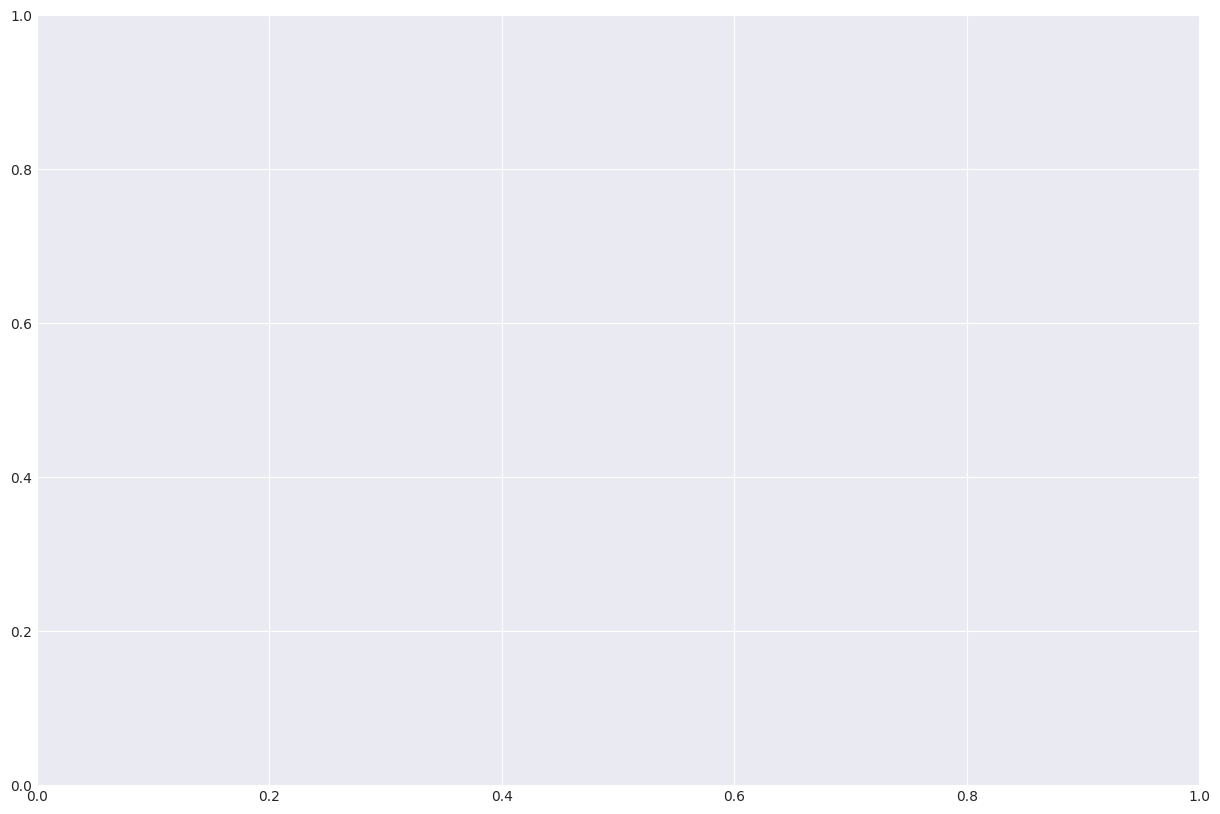

In [7]:
if __name__ == '__main__':
    # --- 0. 新增：CPU核心数配置 ---
    NUM_THREADS = 16
    tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
    tf.config.threading.set_inter_op_parallelism_threads(4)
    logging.info(f"🔧 TensorFlow已配置为使用最多 {NUM_THREADS} 个 intra-op 核心和 4 个 inter-op 核心。")

    # --- 1. 参数配置 ---
    FACTOR_FILE = '/public/data/factor_data/BTCUSDT_15m_2020_2025_factor_data.pkl'
    
    # 回测核心参数
    COMMISSION_RATE = 0.0002
    INITIAL_CAPITAL = 100000
    HOLDING_PERIOD = 10
    
    # ConvLSTM模型参数
    LOOKBACK_PERIOD = 60
    N_SPLITS = 5

    # --- 2. 加载因子数据 ---
    logging.info(f"📂 从 {FACTOR_FILE} 加载因子数据...")
    
    try:
        with open(FACTOR_FILE, 'rb') as f:
            factor_data = pickle.load(f)
        
        # 确保索引是datetime类型
        factor_data.index = pd.to_datetime(factor_data.index)
        
        # 提取收盘价
        close_prices = factor_data['close'].copy()
        
        logging.info(f"✅ 数据加载成功 - 形状: {factor_data.shape}")
        logging.info(f"📅 时间范围: {factor_data.index[0]} 至 {factor_data.index[-1]}")
        logging.info(f"📈 特征数量: {len(factor_data.columns)}")

    except Exception as e:
        logging.error(f"❌ 加载数据时发生错误: {e}")
        factor_data = None

    # --- 3. 将信号生成、回测、评估整合到一个逻辑流中 ---
    if factor_data is not None:
        # 3.1 准备滚动训练数据
        X, y, indices = prepare_rolling_data(factor_data, lookback=LOOKBACK_PERIOD)
        
        # 3.2 执行滚动训练并生成信号
        signals = rolling_train_and_predict(X, y, indices, lookback=LOOKBACK_PERIOD, n_splits=N_SPLITS)
        
        # 3.3 创建与原始数据对齐的完整信号序列
        full_signals = pd.Series(0, index=factor_data.index)
        full_signals.loc[signals.index] = signals
        
        # 3.4 直接调用回测与评估函数，不再进行文件读写
        logging.info("✅ 信号生成完毕，直接进入回测与评估阶段...")
        
        try:
            # 直接使用内存中已有的 `close_prices` 和 `full_signals` 变量
            backtest_results, trade_history = run_realized_pnl_backtest(
                prices=close_prices,
                signals=full_signals,
                initial_capital=INITIAL_CAPITAL,
                commission_rate=COMMISSION_RATE,
                holding_period=HOLDING_PERIOD
            )

            # 紧接着调用评估函数
            evaluate_realized_pnl_performance(
                backtest_results,
                trade_history,
                INITIAL_CAPITAL
            )
        except Exception as e:
            logging.error(f"❌ 在回测或评估过程中发生错误: {e}")

    else:
        # 如果数据加载失败，这里的警告信息也应更新
        logging.warning("⚠️ 由于数据加载失败，跳过模型训练、信号生成和回测步骤。")